In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
from IPython.display import clear_output


In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

## **Download the content and style images to use** **bold text** 

In [3]:
'''
The first style and content images for experiment 1 with the cat picture and painting (water lilies and composition vii)
'''


content_path = tf.keras.utils.get_file('Catpic.jpg',"https://images.freeimages.com/images/large-previews/13e/my-cat-1363423.jpg")
style_path2 = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
style_path1 = tf.keras.utils.get_file('waterlillies.jpg','https://i.imgur.com/Tw2ybIe.jpeg')

In [4]:
'''
The second style and content images for experimenting with contrasting colour and structure. skater picture and two other styles from images unsplash 
Uncomment to use any of the styles and content picture.
'''

# content_path = tf.keras.utils.get_file('skaterpic.jpg',"https://images.unsplash.com/flagged/photo-1565544863956-7619785813fc?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=774&q=80")
# style_path2 = tf.keras.utils.get_file('style_img.jpg','https://images.unsplash.com/photo-1567119715747-ff9c10f46115?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=654&q=80')
# style_path1 = tf.keras.utils.get_file('pop_art.jpg','https://images.unsplash.com/photo-1536759078151-61c8b6f156a8?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=930&q=80')

'\nThe second style and content images for experimenting with contrasting colour and structure. skater picture and two other styles from images unsplash \n\nUncomment to use any of the styles and content picture.\n'

In [5]:
# Function to import images

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  scale = max_dim / max(shape)

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [6]:
# Function to view images

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

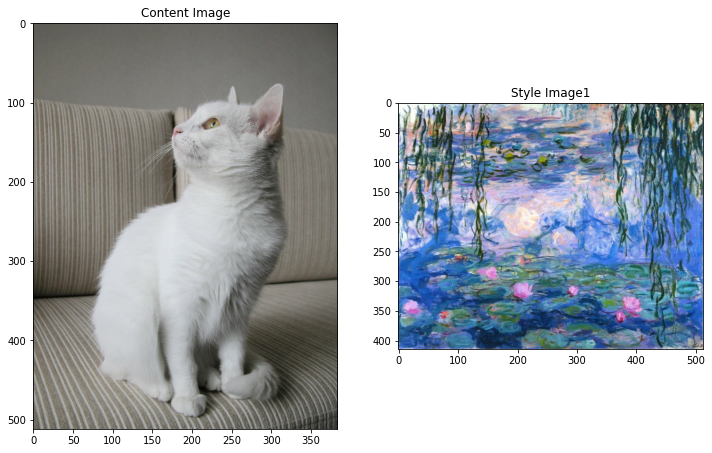

In [7]:
content_image = load_img(content_path)
style_image_1 = load_img(style_path1)
style_image_2 = load_img(style_path2)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image_1, 'Style Image1')




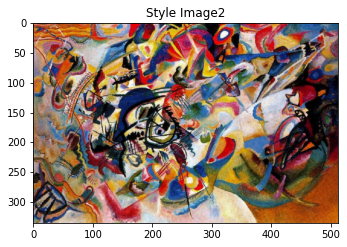

In [8]:

plt.subplot(1, 2, 2)
imshow(style_image_2, 'Style Image2')

VGG19 model class

In [9]:
from tensorflow.keras.applications import vgg19

model = vgg19.VGG19(weights="imagenet", include_top=False)

model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [10]:

'''
layers for feature extractions for content and style
'''


content_layer = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
num_content_layers = len(content_layer)
num_style_layers = len(style_layers)

In [11]:
#gram matrix for feature correlation

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [12]:
'''
class for VGG19 model
'''



class ModelWrapperForVGG19(tf.keras.models.Model):
    def __init__(self, content_layer, style_layers):
        # initialize the parent class        
        super(ModelWrapperForVGG19, self).__init__()
        # make a note of initialization settings
        self.content_layer = content_layer; self.style_layers = style_layers
        # setup the VGG19
        model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        model.trainable = False
        outputs = [model.get_layer(name).output for name in content_layer+style_layers]
        #print(outputs)
        self.vgg19 = tf.keras.Model([model.input], outputs)
        self.vgg19.trainable = False 
    def call(self,input_image):
        model_input = tf.keras.applications.vgg19.preprocess_input(255.0*input_image)
        outputs = self.vgg19(model_input)
        #print(outputs)
        content_nfo, style_nfo = (outputs[0], outputs[1:])
        style_nfo = [gram_matrix(layer) for layer in style_nfo]
        # must reformulate this without a loop, but tensorflow refuses obvious options
        #content_dict = { self.content_layer : content_nfo }
        #content_dict = {}
        #content_dict[self.content_layer] = content_nfo
        content_dict = { layer_name : values
                         for layer_name, values
                         in zip(self.content_layer, content_nfo) }
        style_dict = { layer_name : values
                       for layer_name, values
                       in zip(self.style_layers, style_nfo) }
        return { 'content':content_dict, 'style':style_dict }

# this defines an object (think, function) that, when applied to an image,
# will extract the necessary content/style data from VGG19
feature_extractor = ModelWrapperForVGG19(content_layer, style_layers)

# just a quick test that the code above runs OK
test_run = feature_extractor(tf.constant(content_image))
print(test_run)

{'content': {'block5_conv2': <tf.Tensor: shape=(32, 24, 512), dtype=float32, numpy=
array([[[0.00000000e+00, 0.00000000e+00, 4.12133179e+01, ...,
         0.00000000e+00, 1.63083763e+01, 5.22354937e+00],
        [0.00000000e+00, 0.00000000e+00, 7.18363523e+00, ...,
         0.00000000e+00, 3.04434586e+01, 1.56806111e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 3.76838799e+01, 4.41183090e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 3.16183987e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 2.39554482e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 6.31256402e-01, ...,
         0.00000000e+00, 2.16988087e+01, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 4.39603615e+01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,

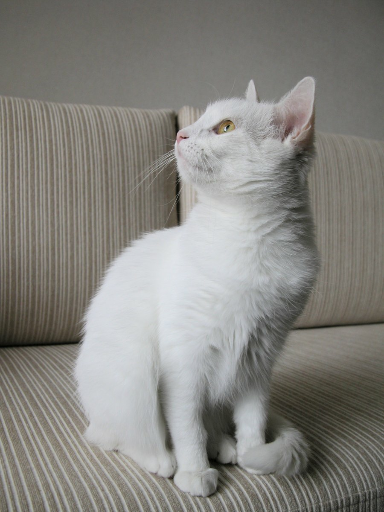

In [13]:

#  INITIALIZATION OF THE IMAGE THAT WE WILL OPTIMIZE. EXTRACTION OF THE TARGET FEATURES
#
def tensor_to_image(tensor):
    array = np.array(tensor*255, dtype=np.uint8)
    if np.ndim(array)>3:
        assert array.shape[0]==1
        array=array[0]
    return PIL.Image.fromarray(array)

# TensorFlow tutorial uses content image as the starting point
image = tf.Variable(content_image)
# you can also start with the random image, but it works VERY slowly
#tf.random.set_seed(1234)
#image = tf.Variable(tf.random.uniform(shape=tf.shape(content_image), minval=0., maxval=1.))
display.display(tensor_to_image(image)) # preview our starting point

# tf.constant ensures that target content layer is pre-calculated once and then used as a constant

content_goal = feature_extractor(tf.constant(content_image))['content']
style_goal_1 = feature_extractor(tf.constant(style_image_1))['style']
style_goal_2 = feature_extractor(tf.constant(style_image_2))['style']

# **COST FUNCTION **

1) Hyper-parameters suhc has content_weight, style_weight and prefer_style_1 and run the optimsation block of code below

In [14]:
#%%
#
#  SETTING UP WEIGHTS AND COST FUNCTION; DEFINING THE TRAINING LOOP
#


'''
This style_content_loss(outputs) function is where the modification takes place. So instead of having 1 style loss, 
we now have two style loss with an additional parameter named prepfer_style_1 and prefer_style_2
'''
content_weight = 0.001
style_weight =  0.01
prefer_style_1 = 0.0
prefer_style_2 = 1-prefer_style_1

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    #style 1 loss 
    style_loss_1 = tf.add_n([tf.reduce_mean((style_outputs[name]-style_goal_1[name])**2) 
                           for name in style_outputs.keys()])
    style_loss_1 *= style_weight / len(style_layers)

    #style 2 loss
    style_loss_2 = tf.add_n([tf.reduce_mean((style_outputs[name]-style_goal_2[name])**2) 
                           for name in style_outputs.keys()])
    style_loss_2 *= style_weight / len(style_layers)

    #content loss
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_goal[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight/num_content_layers
    total_loss = prefer_style_1*style_loss_1 + prefer_style_2*style_loss_2 + content_loss
    return total_loss

# using the same optimizer settings as in the tensor flow tutorial for NST
optimizer=tf.optimizers.Adam(learning_rate=0.025,beta_1=0.99,epsilon=1e-1)
# one step of the training loop

def train_step(image):
    with tf.GradientTape() as tape:
        # the current image featureset 
        features = feature_extractor(image)
        # the value of loss associated with it
        loss = style_content_loss(features)
    # the actual computation takes place here
    grad = tape.gradient(loss,image)
    optimizer.apply_gradients([(grad,image)])
    # pixels must remain in [0,1], but gradients are not aware of this, and
    # can move pixel values outside of the allowed range, so we apply clamping
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))



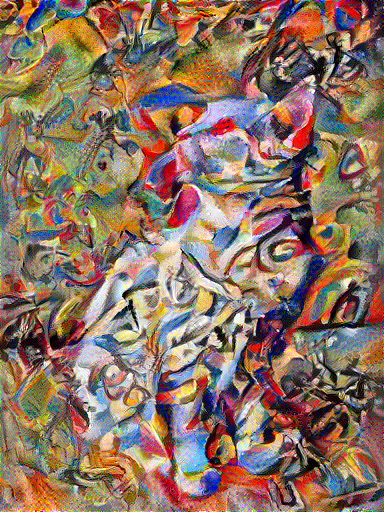

Epoch: 184 (running for 483.8 sec, 2.6 sec per epoch)
Current loss: 1.15e+05
....................

In [ ]:
#%%
#
#  THE OPTIMIZATION with 200 epochs and 20 steps per epoch
#
epochs = 200; steps_per_epoch = 20
losses = []
import time
start = time.time()
for epoch in range(epochs):
    for i in range(steps_per_epoch):
        train_step(image)
        print(".",end='')
    clear_output(wait=True)        
    display.display(tensor_to_image(image))
    cur_time = time.time()
    print("Epoch: {} (running for {:.1f} sec, {:.1f} sec per epoch)".format(epoch+1,cur_time-start,(cur_time-start)/(epoch+1)))
    features = feature_extractor(image)
    current_loss = style_content_loss(features)
    losses.append(current_loss)
    print("Current loss: {:.2e}".format(current_loss))
    
end = time.time()
print("Total time: {:.1f}".format(end-start))

# %%

In [ ]:

import matplotlib.pyplot as plt

plt.xlabel('Epoch')
plt.ylabel('Total loss per epoch')
plt.plot(losses)
plt.show()